In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

In [2]:
#Lines from the excel
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\Visualizer\Clean lines\Nave list NIR.xlsx")
raw_lambda['Nave list'] = (10**8)/raw_lambda['lambda']
raw_lambda = raw_lambda[raw_lambda['Nave list'].between(3950,9120,inclusive='right')] #Separate the range for use

In [3]:
# Values.to_excel('valores_Nave.xlsx',index=False)
#Save the data before the code

In [4]:
#Data from vizier without treatment
# raw_data = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\Visualizer\Datos_prueba.xlsx")

raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\NIR_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])

#Convert the wavelength in A cause its in cm^-1 
raw_data['Wave A'] = (10**(8))/raw_data['Wave (cm)']

#Invert the values for the index in python
raw_data = raw_data.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

In [23]:
#Lines from the excel
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\Visualizer\Clean lines\Nave list NIR.xlsx")
raw_lambda['Nave list'] = (10**8)/raw_lambda['lambda']
raw_lambda = raw_lambda[raw_lambda['Nave list'].between(10000,23000,inclusive='right')]
raw_lambda = raw_lambda[raw_lambda['class']=='A'].reset_index(drop=True)

raw_lambda

,lambda,class,Nave list
0,9977.511,A,10022.539690
1,9975.027,A,10025.035521
2,9971.253,A,10028.829877
3,9964.517,A,10035.609353
4,9955.970,A,10044.224721
...,...,...,...
1849,4378.553,A,22838.595308
1850,4375.952,A,22852.170225
1851,4368.958,A,22888.752879
1852,4354.970,A,22962.270693


### Find the minimums and the closer line of the Fe I line


In [35]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda
    closer_data = closer_data[closer_data['abs'] <= 0.01].reset_index(drop=True)

    return closer_data.drop(['abs'],axis=1)

#Closer lines
closer_lines = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])

closer_lines

,min_wave,min_flux,Fe line
0,10022.532502,0.946571,10022.539690
1,10025.030255,0.957562,10025.035521
2,10028.834148,0.965678,10028.829877
3,10035.604601,0.942222,10035.609353
4,10067.811226,0.611177,10067.804651
...,...,...,...
680,22585.057297,0.932716,22585.053618
681,22708.603212,1.080441,22708.605222
682,22741.242362,1.058126,22741.232743
683,22776.564192,1.017026,22776.558093


In [36]:
#Localize the line and save the width for lines
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points

local_points = width_minimums(closer_lines,raw_data,0.05)

### Filter for the lines using the second derivate

In [37]:
def Fit_derivates(local_points,closer_lines):
    values = []
    fit = []
    local = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of lines 

        #Internal rise, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #take the conditional for the division in zero

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second

        flux_fit = poly.polyval(wave_scaled,param) #Evaluate the fit

        #First condition: The parameter of the order two polynomium need to be positive.
        #Second condition (for eliminate lineal terms): The distance between the initial and the final point need to be less than the half of depth
        #In other words, the final point need to be higher than the half of the distance between extreme points
  
        if d2_param[0]>0 and (data_flux.iloc[-1])>=(np.abs(data_flux.iloc[0]-data_flux.iloc[-1])/2):
    
            values.append(pd.DataFrame([[closer_lines['Fe line'].iloc[i],closer_lines['min_wave'].iloc[i],closer_lines['min_flux'].iloc[i]]])) 
            fit.append(flux_fit)
            local.append(local_points[i])

    Values = pd.concat(values,axis=0).reset_index(drop=True)

    Values.columns = ["Line Fe I",'min_wave','min_flux']

    return Values,fit,local

Values,fit,local = Fit_derivates(local_points,closer_lines)

Values

,Line Fe I,min_wave,min_flux
0,10022.539690,10022.532502,0.946571
1,10025.035521,10025.030255,0.957562
2,10028.829877,10028.834148,0.965678
3,10035.609353,10035.604601,0.942222
4,10067.804651,10067.811226,0.611177
...,...,...,...
521,22558.148138,22558.153410,0.987382
522,22708.605222,22708.603212,1.080441
523,22741.232743,22741.242362,1.058126
524,22776.558093,22776.564192,1.017026


In [9]:
# Values.to_excel('valores_NIR_prueba.xlsx',index=False)

## Visualizer for the Fe I lines one by one

In [ ]:
# import tkinter as tk
# from tkinter import ttk
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
# import numpy as np

# class OutlierViewer:
#     def __init__(self, root, local_points, values,fit):
#         self.root = root
#         self.root.title("Visualizer of Fe I lines identification")
#         self.local_points = local_points
#         self.values = values
#         self.fit = fit
#         self.index = values.index.values
#         self.current_index = 0
       
#         self.setup_ui()
#         self.update_plot()
    
#     def setup_ui(self):
#         main_frame = ttk.Frame(self.root, padding="10")
#         main_frame.pack(fill=tk.BOTH, expand=True)
        
#         control_frame = ttk.Frame(main_frame)
#         control_frame.pack(fill=tk.X, pady=10)
        
#         ttk.Label(control_frame, text="Index of the line:").pack(side=tk.LEFT, padx=5)
#         self.slider = ttk.Scale(
#             control_frame,
#             from_=0,
#             to=len(self.index)-1,
#             orient=tk.HORIZONTAL,
#             command=self.on_slider_move
#         )
#         self.slider.pack(side=tk.LEFT, expand=True, fill=tk.X, padx=5)
        
#         self.spinbox = ttk.Spinbox(
#             control_frame,
#             from_=0,
#             to=len(self.index)-1,
#             width=5,
#             command=self.on_spinbox_change
#         )
#         self.spinbox.pack(side=tk.LEFT, padx=5)
#         self.spinbox.bind("<Return>", self.on_spinbox_change)
        
#         nav_frame = ttk.Frame(control_frame)
#         nav_frame.pack(side=tk.LEFT, padx=10)
        
#         ttk.Button(nav_frame, text="← Last", command=self.prev_plot).pack(side=tk.LEFT)
#         ttk.Button(nav_frame, text="Next →", command=self.next_plot).pack(side=tk.LEFT, padx=5)
     
#         graph_frame = ttk.Frame(main_frame)
#         graph_frame.pack(fill=tk.BOTH, expand=True)
       
#         self.fig, self.ax = plt.subplots(figsize=(10, 6))
#         self.canvas = FigureCanvasTkAgg(self.fig, master=graph_frame)
#         self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
#         self.toolbar = NavigationToolbar2Tk(self.canvas, graph_frame)
#         self.toolbar.update()
#         self.canvas._tkcanvas.pack(fill=tk.BOTH, expand=True)
    
#     def on_slider_move(self, event=None):
#         self.current_index = int(float(self.slider.get()))
#         self.spinbox.delete(0, tk.END)
#         self.spinbox.insert(0, str(self.current_index))
#         self.update_plot()
    
#     def on_spinbox_change(self, event=None):
#         try:
#             new_index = int(self.spinbox.get())
#             if 0 <= new_index < len(self.index):
#                 self.current_index = new_index
#                 self.slider.set(self.current_index)
#                 self.update_plot()
#         except ValueError:
#             pass
    
#     def prev_plot(self):
#         if self.current_index > 0:
#             self.current_index -= 1
#             self.slider.set(self.current_index)
#             self.spinbox.delete(0, tk.END)
#             self.spinbox.insert(0, str(self.current_index))
#             self.update_plot()
    
#     def next_plot(self):
#         if self.current_index < len(self.index)-1:
#             self.current_index += 1
#             self.slider.set(self.current_index)
#             self.spinbox.delete(0, tk.END)
#             self.spinbox.insert(0, str(self.current_index))
#             self.update_plot()
    
#     #Graficas
#     def update_plot(self):
#         j = self.current_index
#         self.ax.clear()
        
#         # Gráfica principal
#         self.ax.plot(
#             self.local_points[j]['Wave A'],
#             self.local_points[j]['nFlux'],
#             color='orange',
#             label='Spectrum'
#         )
        
#         #Closer lines
#         self.ax.plot(
#             self.local_points[j]['Wave A'],
#             self.fit[j],
#             color='blue',
#             label='Fit',
#             marker='.',
#         )
        
#         #Fe I line
#         self.ax.scatter(
#             self.values["Line Fe I"][j],
#             self.values['min_flux'][j],
#             color='red',
#             label='Fe I',
#             s=100
#         )

#         #Fe I line
#         self.ax.scatter(
#             self.values['min_wave'][j],
#             self.values["min_flux"][j],
#             color='blue',
#             s=100
#         )
        
#         #Vainitas del gráfico
#         self.ax.set_title(f'Visualizer - Index {self.index[j]} - Wave {self.values["Line Fe I"][j]} Å')
#         self.ax.set_xlabel(r'Wavelength $(\mathring{A})$')
#         self.ax.set_ylabel('Flux')
#         self.ax.legend()
#         self.ax.grid(True)
        
#         self.canvas.draw()


# if __name__ == "__main__":
#     root = tk.Tk()
#     root.geometry("900x700")
    
    
#     app = OutlierViewer(root, local, Values,fit)

#     root.mainloop()

Agregada estrella green para índice 0
Calificaciones actuales: {0: ['green']}
Agregada estrella red para índice 1
Calificaciones actuales: {0: ['green'], 1: ['red']}
Agregada estrella red para índice 2
Calificaciones actuales: {0: ['green'], 1: ['red'], 2: ['red']}
Agregada estrella red para índice 3
Calificaciones actuales: {0: ['green'], 1: ['red'], 2: ['red'], 3: ['red']}


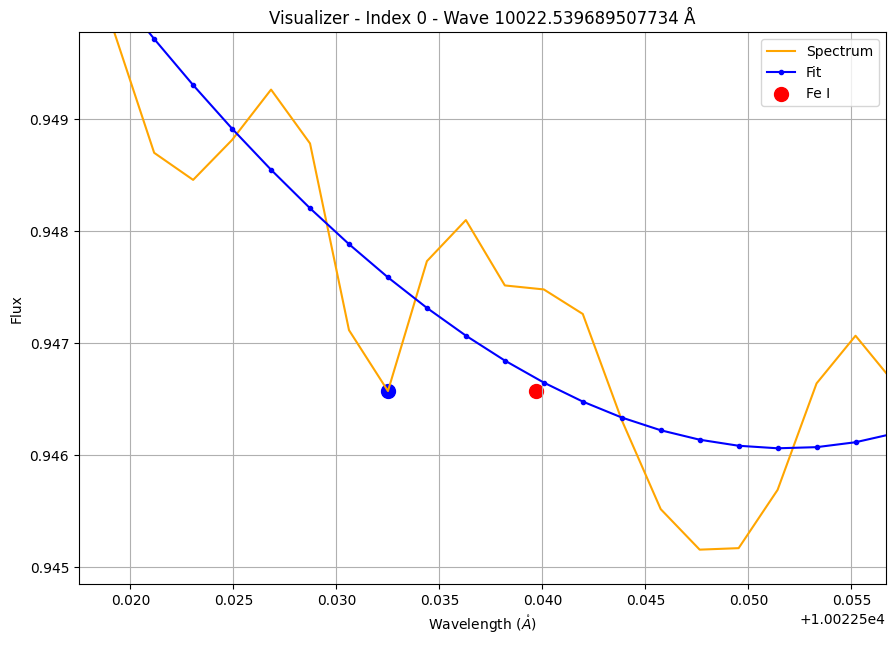

In [39]:
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
import numpy as np
import pandas as pd

class OutlierViewer:
    def __init__(self, root, local_points, values, fit):
        self.root = root
        self.root.title("Visualizer of Fe I lines identification")
        self.local_points = local_points
        self.values = values
        self.fit = fit
        self.index = values.index.values
        self.current_index = 0
        
        # Diccionario para almacenar las estrellas por índice
        self.star_ratings = {}  # {index: [color1, color2, ...]}
        self.star_labels = []   # Labels actualmente mostrados
        
        self.setup_ui()
        self.update_plot()
    
    def setup_ui(self):
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.pack(fill=tk.BOTH, expand=True)
        
        # Frame para el título y estrellas
        title_frame = ttk.Frame(main_frame)
        title_frame.pack(fill=tk.X, pady=(0, 10))
        
        # Label del título (se actualizará en update_plot)
        self.title_label = ttk.Label(
            title_frame, 
            text="Visualizer of Fe I lines identification", 
            font=("Arial", 12, "bold")
        )
        self.title_label.pack(side=tk.LEFT)
        
        # Frame para las estrellas (al lado del título)
        self.stars_frame = ttk.Frame(title_frame)
        self.stars_frame.pack(side=tk.LEFT, padx=(10, 0))
        
        control_frame = ttk.Frame(main_frame)
        control_frame.pack(fill=tk.X, pady=10)
        
        ttk.Label(control_frame, text="Index of the line:").pack(side=tk.LEFT, padx=5)
        self.slider = ttk.Scale(
            control_frame,
            from_=0,
            to=len(self.index)-1,
            orient=tk.HORIZONTAL,
            command=self.on_slider_move
        )
        self.slider.pack(side=tk.LEFT, expand=True, fill=tk.X, padx=5)
        
        self.spinbox = ttk.Spinbox(
            control_frame,
            from_=0,
            to=len(self.index)-1,
            width=5,
            command=self.on_spinbox_change
        )
        self.spinbox.pack(side=tk.LEFT, padx=5)
        self.spinbox.bind("<Return>", self.on_spinbox_change)
        
        nav_frame = ttk.Frame(control_frame)
        nav_frame.pack(side=tk.LEFT, padx=10)
        
        ttk.Button(nav_frame, text="← Last", command=self.prev_plot).pack(side=tk.LEFT)
        ttk.Button(nav_frame, text="Next →", command=self.next_plot).pack(side=tk.LEFT, padx=5)
     
        graph_frame = ttk.Frame(main_frame)
        graph_frame.pack(fill=tk.BOTH, expand=True)
       
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        self.canvas = FigureCanvasTkAgg(self.fig, master=graph_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        self.toolbar = NavigationToolbar2Tk(self.canvas, graph_frame)
        self.toolbar.update()
        self.canvas._tkcanvas.pack(fill=tk.BOTH, expand=True)
        
        # Frame para los botones de estrellas en la parte inferior
        self.crear_botones_estrellas(main_frame)
    
    def crear_botones_estrellas(self, parent):
        # Frame para botones en la parte inferior
        buttons_frame = ttk.Frame(parent)
        buttons_frame.pack(fill=tk.X, pady=(20, 0))
        
        # Label para indicar la función de los botones
        ttk.Label(buttons_frame, text="Rate line:").pack(side=tk.LEFT, padx=(0, 10))
        
        # Botones de estrellas
        self.btn_verde = self.crear_boton_estrella(buttons_frame, "★", "green", 
                                                  lambda: self.agregar_estrella("green"))
        self.btn_amarillo = self.crear_boton_estrella(buttons_frame, "★", "yellow", 
                                                     lambda: self.agregar_estrella("yellow"))
        self.btn_rojo = self.crear_boton_estrella(buttons_frame, "★", "red", 
                                                 lambda: self.agregar_estrella("red"))
    
    def crear_boton_estrella(self, parent, text, color, command):
        btn = ttk.Button(parent, text=text, command=command, width=3)
        btn.pack(side=tk.LEFT, padx=5)
        
        # Configurar color (usando estilo)
        style = ttk.Style()
        style_name = f"Star.{color}.TButton"
        style.configure(style_name, foreground=color, font=("Arial", 12, "bold"))
        btn.configure(style=style_name)
        
        return btn
    
    def agregar_estrella(self, color):
        # Agregar la estrella al diccionario de calificaciones
        if self.current_index not in self.star_ratings:
            self.star_ratings[self.current_index] = []
        
        self.star_ratings[self.current_index].append(color)
        
        # Actualizar la visualización de estrellas
        self.actualizar_estrellas_visualizacion()
        
        print(f"Agregada estrella {color} para índice {self.current_index}")
        print(f"Calificaciones actuales: {self.star_ratings}")
    
    def actualizar_estrellas_visualizacion(self):
        # Limpiar estrellas actuales
        self.limpiar_estrellas_visualizacion()
        
        # Mostrar estrellas del índice actual
        if self.current_index in self.star_ratings:
            for color in self.star_ratings[self.current_index]:
                star_label = ttk.Label(self.stars_frame, text="★", 
                                      foreground=color, 
                                      font=("Arial", 14, "bold"))
                star_label.pack(side=tk.LEFT, padx=2)
                self.star_labels.append(star_label)
    
    def limpiar_estrellas_visualizacion(self):
        # Eliminar solo las estrellas visualizadas, no los datos
        for label in self.star_labels:
            label.destroy()
        self.star_labels = []
    
    def on_slider_move(self, event=None):
        self.current_index = int(float(self.slider.get()))
        self.spinbox.delete(0, tk.END)
        self.spinbox.insert(0, str(self.current_index))
        self.update_plot()
        # Actualizar la visualización de estrellas
        self.actualizar_estrellas_visualizacion()
    
    def on_spinbox_change(self, event=None):
        try:
            new_index = int(self.spinbox.get())
            if 0 <= new_index < len(self.index):
                self.current_index = new_index
                self.slider.set(self.current_index)
                self.update_plot()
                # Actualizar la visualización de estrellas
                self.actualizar_estrellas_visualizacion()
        except ValueError:
            pass
    
    def prev_plot(self):
        if self.current_index > 0:
            self.current_index -= 1
            self.slider.set(self.current_index)
            self.spinbox.delete(0, tk.END)
            self.spinbox.insert(0, str(self.current_index))
            self.update_plot()
            # Actualizar la visualización de estrellas
            self.actualizar_estrellas_visualizacion()
    
    def next_plot(self):
        if self.current_index < len(self.index)-1:
            self.current_index += 1
            self.slider.set(self.current_index)
            self.spinbox.delete(0, tk.END)
            self.spinbox.insert(0, str(self.current_index))
            self.update_plot()
            # Actualizar la visualización de estrellas
            self.actualizar_estrellas_visualizacion()
    
    # Graficas
    def update_plot(self):
        j = self.current_index
        self.ax.clear()
        
        # Gráfica principal
        self.ax.plot(
            self.local_points[j]['Wave A'],
            self.local_points[j]['nFlux'],
            color='orange',
            label='Spectrum'
        )
        
        # Closer lines
        self.ax.plot(
            self.local_points[j]['Wave A'],
            self.fit[j],
            color='blue',
            label='Fit',
            marker='.',
        )
        
        # Fe I line
        self.ax.scatter(
            self.values["Line Fe I"][j],
            self.values['min_flux'][j],
            color='red',
            label='Fe I',
            s=100
        )

        # Fe I line
        self.ax.scatter(
            self.values['min_wave'][j],
            self.values["min_flux"][j],
            color='blue',
            s=100
        )
        
        # Actualizar título con la información actual
        title_text = f'Visualizer - Index {self.index[j]} - Wave {self.values["Line Fe I"][j]} Å'
        self.ax.set_title(title_text)
        
        # También actualizar el label del título en la interfaz
        self.title_label.config(text=title_text)
        
        # Vainitas del gráfico
        self.ax.set_xlabel(r'Wavelength $(\mathring{A})$')
        self.ax.set_ylabel('Flux')
        self.ax.legend()
        self.ax.grid(True)
        
        self.canvas.draw()


if __name__ == "__main__":
    root = tk.Tk()
    root.geometry("900x700")
    
    # Aquí deberías cargar tus datos reales
    app = OutlierViewer(root, local, Values, fit)
    
    root.mainloop()

Agregada estrella red para índice 0
Calificaciones actuales: {0: ['red']}


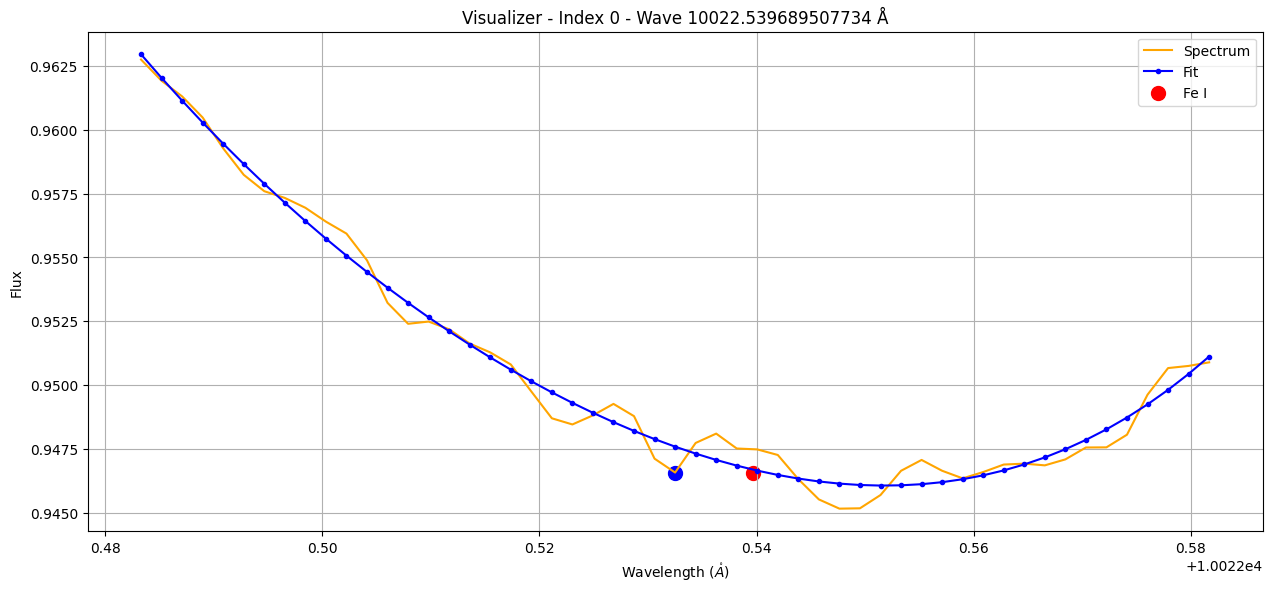

In [43]:
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
import numpy as np
import pandas as pd

class OutlierViewer:
    def __init__(self, root, local_points, values, fit):
        self.root = root
        self.root.title("Visualizer of Fe I lines identification")
        self.local_points = local_points
        self.values = values
        self.fit = fit
        self.index = values.index.values
        self.current_index = 0
        
        # Diccionario para almacenar las estrellas por índice
        self.star_ratings = {}  # {index: [color1, color2, ...]}
        self.star_labels = []   # Labels actualmente mostrados
        
        self.setup_ui()
        self.update_plot()
    
    def setup_ui(self):
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.pack(fill=tk.BOTH, expand=True)
        
        # Frame para el título y estrellas
        title_frame = ttk.Frame(main_frame)
        title_frame.pack(fill=tk.X, pady=(0, 10))
        
        # Label del título (se actualizará en update_plot)
        self.title_label = ttk.Label(
            title_frame, 
            text="Visualizer of Fe I lines identification", 
            font=("Arial", 12, "bold")
        )
        self.title_label.pack(side=tk.LEFT)
        
        # Frame para las estrellas (al lado del título)
        self.stars_frame = ttk.Frame(title_frame)
        self.stars_frame.pack(side=tk.LEFT, padx=(10, 0))
        
        control_frame = ttk.Frame(main_frame)
        control_frame.pack(fill=tk.X, pady=10)
        
        ttk.Label(control_frame, text="Index of the line:").pack(side=tk.LEFT, padx=5)
        
        # Slider con color personalizado
        self.slider = tk.Scale(
            control_frame,
            from_=0,
            to=len(self.index)-1,
            orient=tk.HORIZONTAL,
            command=self.on_slider_move,
            length=400,
            sliderlength=20,
            showvalue=False,
            bg='lightblue',  # Color de fondo de la barra
            troughcolor='darkblue',  # Color del canal de la barra
            highlightbackground='gray',
            highlightcolor='blue'
        )
        self.slider.pack(side=tk.LEFT, expand=True, fill=tk.X, padx=5)
        
        self.spinbox = ttk.Spinbox(
            control_frame,
            from_=0,
            to=len(self.index)-1,
            width=5,
            command=self.on_spinbox_change
        )
        self.spinbox.pack(side=tk.LEFT, padx=5)
        self.spinbox.bind("<Return>", self.on_spinbox_change)
        
        nav_frame = ttk.Frame(control_frame)
        nav_frame.pack(side=tk.LEFT, padx=10)
        
        ttk.Button(nav_frame, text="← Last", command=self.prev_plot).pack(side=tk.LEFT)
        ttk.Button(nav_frame, text="Next →", command=self.next_plot).pack(side=tk.LEFT, padx=5)
     
        graph_frame = ttk.Frame(main_frame)
        graph_frame.pack(fill=tk.BOTH, expand=True)
       
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        self.canvas = FigureCanvasTkAgg(self.fig, master=graph_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Toolbar estándar
        self.toolbar = NavigationToolbar2Tk(self.canvas, graph_frame)
        self.toolbar.update()
        self.canvas._tkcanvas.pack(fill=tk.BOTH, expand=True)
        
        # Frame para los botones de estrellas en la parte inferior
        self.crear_botones_estrellas(main_frame)
    
    def crear_botones_estrellas(self, parent):
        # Frame para botones en la parte inferior
        buttons_frame = ttk.Frame(parent)
        buttons_frame.pack(fill=tk.X, pady=(20, 0))
        
        # Label para indicar la función de los botones
        ttk.Label(buttons_frame, text="Rate line:").pack(side=tk.LEFT, padx=(0, 10))
        
        # Botones de estrellas
        self.btn_verde = self.crear_boton_estrella(buttons_frame, "★", "green", 
                                                  lambda: self.agregar_estrella("green"))
        self.btn_amarillo = self.crear_boton_estrella(buttons_frame, "★", "yellow", 
                                                     lambda: self.agregar_estrella("yellow"))
        self.btn_rojo = self.crear_boton_estrella(buttons_frame, "★", "red", 
                                                 lambda: self.agregar_estrella("red"))
        
        # Botón para guardar imagen
        ttk.Separator(buttons_frame, orient=tk.VERTICAL).pack(side=tk.LEFT, padx=10, fill=tk.Y)
        ttk.Button(buttons_frame, text="💾 Save JPG", 
                  command=self.guardar_imagen).pack(side=tk.LEFT, padx=5)
    
    def crear_boton_estrella(self, parent, text, color, command):
        btn = ttk.Button(parent, text=text, command=command, width=3)
        btn.pack(side=tk.LEFT, padx=5)
        
        # Configurar color (usando estilo)
        style = ttk.Style()
        style_name = f"Star.{color}.TButton"
        style.configure(style_name, foreground=color, font=("Arial", 12, "bold"))
        btn.configure(style=style_name)
        
        return btn
    
    def guardar_imagen(self):
        """Guarda la gráfica actual como archivo JPG"""
        try:
            # Generar nombre de archivo con información de la gráfica actual
            filename = f"fe_line_{self.current_index}_wave_{self.values['Line Fe I'].iloc[self.current_index]:.2f}.jpg"
            
            # Guardar la figura con alta calidad
            self.fig.savefig(filename, 
                           format='jpg', 
                           dpi=300, 
                           bbox_inches='tight', 
                           facecolor='white',
                           edgecolor='none')
            
            print(f"Gráfica guardada como: {filename}")
            
            # Mostrar mensaje de confirmación
            from tkinter import messagebox
            messagebox.showinfo("Éxito", f"Imagen guardada como:\n{filename}")
            
        except Exception as e:
            from tkinter import messagebox
            messagebox.showerror("Error", f"No se pudo guardar la imagen: {str(e)}")
            print(f"Error al guardar: {e}")
    
    def agregar_estrella(self, color):
        # Agregar la estrella al diccionario de calificaciones
        if self.current_index not in self.star_ratings:
            self.star_ratings[self.current_index] = []
        
        self.star_ratings[self.current_index].append(color)
        
        # Actualizar la visualización de estrellas
        self.actualizar_estrellas_visualizacion()
        
        print(f"Agregada estrella {color} para índice {self.current_index}")
        print(f"Calificaciones actuales: {self.star_ratings}")
    
    def actualizar_estrellas_visualizacion(self):
        # Limpiar estrellas actuales
        self.limpiar_estrellas_visualizacion()
        
        # Mostrar estrellas del índice actual
        if self.current_index in self.star_ratings:
            for color in self.star_ratings[self.current_index]:
                star_label = ttk.Label(self.stars_frame, text="★", 
                                      foreground=color, 
                                      font=("Arial", 14, "bold"))
                star_label.pack(side=tk.LEFT, padx=2)
                self.star_labels.append(star_label)
    
    def limpiar_estrellas_visualizacion(self):
        # Eliminar solo las estrellas visualizadas, no los datos
        for label in self.star_labels:
            label.destroy()
        self.star_labels = []
    
    def on_slider_move(self, event=None):
        self.current_index = int(float(self.slider.get()))
        self.spinbox.delete(0, tk.END)
        self.spinbox.insert(0, str(self.current_index))
        self.update_plot()
        # Actualizar la visualización de estrellas
        self.actualizar_estrellas_visualizacion()
    
    def on_spinbox_change(self, event=None):
        try:
            new_index = int(self.spinbox.get())
            if 0 <= new_index < len(self.index):
                self.current_index = new_index
                self.slider.set(self.current_index)
                self.update_plot()
                # Actualizar la visualización de estrellas
                self.actualizar_estrellas_visualizacion()
        except ValueError:
            pass
    
    def prev_plot(self):
        if self.current_index > 0:
            self.current_index -= 1
            self.slider.set(self.current_index)
            self.spinbox.delete(0, tk.END)
            self.spinbox.insert(0, str(self.current_index))
            self.update_plot()
            # Actualizar la visualización de estrellas
            self.actualizar_estrellas_visualizacion()
    
    def next_plot(self):
        if self.current_index < len(self.index)-1:
            self.current_index += 1
            self.slider.set(self.current_index)
            self.spinbox.delete(0, tk.END)
            self.spinbox.insert(0, str(self.current_index))
            self.update_plot()
            # Actualizar la visualización de estrellas
            self.actualizar_estrellas_visualizacion()
    
    # Graficas
    def update_plot(self):
        j = self.current_index
        self.ax.clear()
        
        # Gráfica principal
        self.ax.plot(
            self.local_points[j]['Wave A'],
            self.local_points[j]['nFlux'],
            color='orange',
            label='Spectrum'
        )
        
        # Closer lines
        self.ax.plot(
            self.local_points[j]['Wave A'],
            self.fit[j],
            color='blue',
            label='Fit',
            marker='.',
        )
        
        # Fe I line
        self.ax.scatter(
            self.values["Line Fe I"][j],
            self.values['min_flux'][j],
            color='red',
            label='Fe I',
            s=100
        )

        # Fe I line
        self.ax.scatter(
            self.values['min_wave'][j],
            self.values["min_flux"][j],
            color='blue',
            s=100
        )
        
        # Actualizar título con la información actual
        title_text = f'Visualizer - Index {self.index[j]} - Wave {self.values["Line Fe I"][j]} Å'
        self.ax.set_title(title_text)
        
        # También actualizar el label del título en la interfaz
        self.title_label.config(text=title_text)
        
        # Vainitas del gráfico
        self.ax.set_xlabel(r'Wavelength $(\mathring{A})$')
        self.ax.set_ylabel('Flux')
        self.ax.legend()
        self.ax.grid(True)
        
        self.canvas.draw()


if __name__ == "__main__":
    root = tk.Tk()
    root.geometry("900x700")
    
    # Aquí deberías cargar tus datos reales
    app = OutlierViewer(root, local, Values, fit)
    
    root.mainloop()

Agregada estrella green para índice 0
Calificaciones actuales: {0: ['green']}


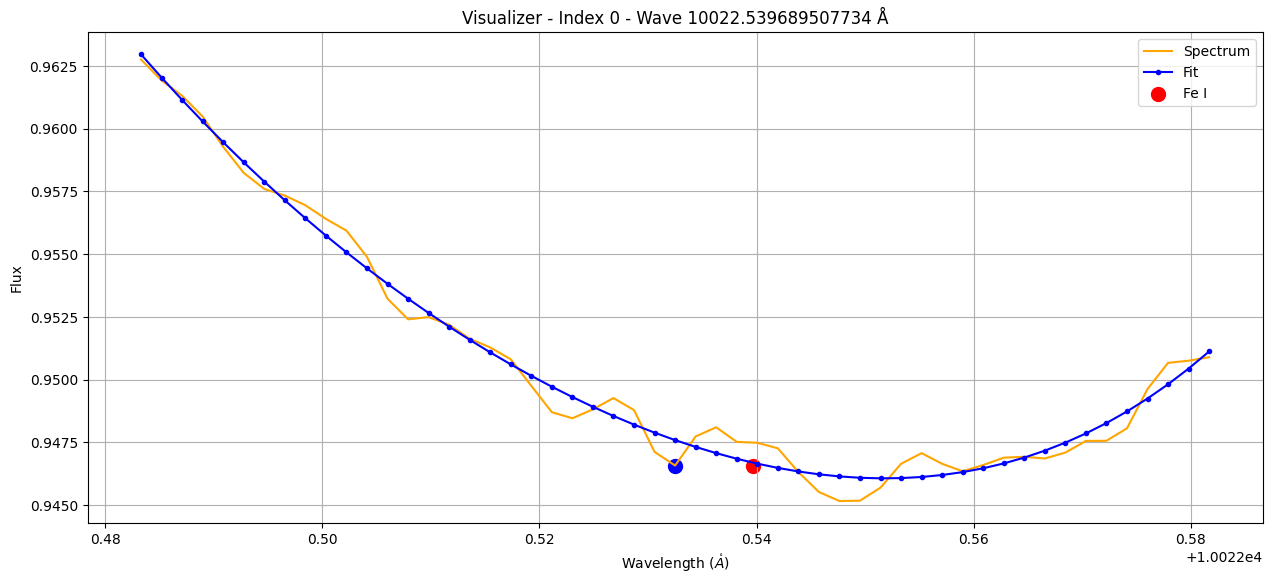

In [ ]:
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
import numpy as np
import pandas as pd

class OutlierViewer:
    def __init__(self, root, local_points, values, fit):
        self.root = root
        self.root.title("Visualizer of Fe I lines identification")
        self.local_points = local_points
        self.values = values
        self.fit = fit
        self.index = values.index.values
        self.current_index = 0
        
        # Diccionario para almacenar las estrellas por índice
        self.star_ratings = {}  # {index: [color1, color2, ...]}
        self.star_labels = []   # Labels actualmente mostrados
        
        self.setup_ui()
        self.update_plot()
    
    def setup_ui(self):
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.pack(fill=tk.BOTH, expand=True)
        
        # Frame para el título y estrellas
        title_frame = ttk.Frame(main_frame)
        title_frame.pack(fill=tk.X, pady=(0, 10))
        
        # Label del título (se actualizará en update_plot)
        self.title_label = ttk.Label(
            title_frame, 
            text="Visualizer of Fe I lines identification", 
            font=("Arial", 12, "bold")
        )
        self.title_label.pack(side=tk.LEFT)
        
        # Frame para las estrellas (al lado del título)
        self.stars_frame = ttk.Frame(title_frame)
        self.stars_frame.pack(side=tk.LEFT, padx=(10, 0))
        
        # Frame para los botones de estrellas (al lado del título)
        self.star_buttons_frame = ttk.Frame(title_frame)
        self.star_buttons_frame.pack(side=tk.LEFT, padx=(20, 0))
        
        # Agregar botones de estrellas al lado del título
        self.crear_botones_estrellas(self.star_buttons_frame)
        
        control_frame = ttk.Frame(main_frame)
        control_frame.pack(fill=tk.X, pady=10)
        
        ttk.Label(control_frame, text="Index of the line:").pack(side=tk.LEFT, padx=5)
        
        # Slider con color personalizado
        self.slider = tk.Scale(
            control_frame,
            from_=0,
            to=len(self.index)-1,
            orient=tk.HORIZONTAL,
            command=self.on_slider_move,
            length=400,
            sliderlength=20,
            showvalue=False,
            bg='lightblue',  # Color de fondo de la barra
            troughcolor='darkblue',  # Color del canal de la barra
            highlightbackground='gray',
            highlightcolor='blue'
        )
        self.slider.pack(side=tk.LEFT, expand=True, fill=tk.X, padx=5)
        
        self.spinbox = ttk.Spinbox(
            control_frame,
            from_=0,
            to=len(self.index)-1,
            width=5,
            command=self.on_spinbox_change
        )
        self.spinbox.pack(side=tk.LEFT, padx=5)
        self.spinbox.bind("<Return>", self.on_spinbox_change)
        
        nav_frame = ttk.Frame(control_frame)
        nav_frame.pack(side=tk.LEFT, padx=10)
        
        ttk.Button(nav_frame, text="← Last", command=self.prev_plot).pack(side=tk.LEFT)
        ttk.Button(nav_frame, text="Next →", command=self.next_plot).pack(side=tk.LEFT, padx=5)
     
        graph_frame = ttk.Frame(main_frame)
        graph_frame.pack(fill=tk.BOTH, expand=True)
       
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        self.canvas = FigureCanvasTkAgg(self.fig, master=graph_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Toolbar estándar
        self.toolbar = NavigationToolbar2Tk(self.canvas, graph_frame)
        self.toolbar.update()
        self.canvas._tkcanvas.pack(fill=tk.BOTH, expand=True)
        
        # Frame para los botones inferiores con color aquamarina
        self.crear_botones_inferiores(main_frame)
    
    def crear_botones_estrellas(self, parent):
        """Crea los botones de estrellas y los coloca en el frame especificado"""
        # Label para indicar la función de los botones
        ttk.Label(parent, text="Rate:", font=("Arial", 9)).pack(side=tk.LEFT, padx=(0, 5))
        
        # Botones de estrellas
        self.btn_verde = self.crear_boton_estrella(parent, "★", "green", 
                                                  lambda: self.agregar_estrella("green"))
        self.btn_amarillo = self.crear_boton_estrella(parent, "★", "yellow", 
                                                     lambda: self.agregar_estrella("yellow"))
        self.btn_rojo = self.crear_boton_estrella(parent, "★", "red", 
                                                 lambda: self.agregar_estrella("red"))
    
    def crear_botones_inferiores(self, parent):
        """Crea los botones inferiores con color aquamarina"""
        # Frame para botones en la parte inferior con color aquamarina
        buttons_frame = tk.Frame(parent, bg='aquamarine', height=40)
        buttons_frame.pack(fill=tk.X, pady=(20, 0))
        buttons_frame.pack_propagate(False)  # Evita que el frame se encoja
        
        # Botón para guardar imagen centrado
        save_button = ttk.Button(buttons_frame, text="💾 Save JPG", 
                               command=self.guardar_imagen)
        save_button.place(relx=0.5, rely=0.5, anchor=tk.CENTER)
    
    def crear_boton_estrella(self, parent, text, color, command):
        btn = ttk.Button(parent, text=text, command=command, width=2)
        btn.pack(side=tk.LEFT, padx=2)
        
        # Configurar color (usando estilo)
        style = ttk.Style()
        style_name = f"Star.{color}.TButton"
        style.configure(style_name, foreground=color, font=("Arial", 10, "bold"))
        btn.configure(style=style_name)
        
        return btn
    
    def guardar_imagen(self):
        """Guarda la gráfica actual como archivo JPG"""
        try:
            # Generar nombre de archivo con información de la gráfica actual
            filename = f"fe_line_{self.current_index}_wave_{self.values['Line Fe I'].iloc[self.current_index]:.2f}.jpg"
            
            # Guardar la figura con alta calidad
            self.fig.savefig(filename, 
                           format='jpg', 
                           dpi=300, 
                           bbox_inches='tight', 
                           facecolor='white',
                           edgecolor='none')
            
            print(f"Gráfica guardada como: {filename}")
            
            # Mostrar mensaje de confirmación
            from tkinter import messagebox
            messagebox.showinfo("Éxito", f"Imagen guardada como:\n{filename}")
            
        except Exception as e:
            from tkinter import messagebox
            messagebox.showerror("Error", f"No se pudo guardar la imagen: {str(e)}")
            print(f"Error al guardar: {e}")
    
    def agregar_estrella(self, color):
        # Agregar la estrella al diccionario de calificaciones
        if self.current_index not in self.star_ratings:
            self.star_ratings[self.current_index] = []
        
        self.star_ratings[self.current_index].append(color)
        
        # Actualizar la visualización de estrellas
        self.actualizar_estrellas_visualizacion()
        
        print(f"Agregada estrella {color} para índice {self.current_index}")
        print(f"Calificaciones actuales: {self.star_ratings}")
    
    def actualizar_estrellas_visualizacion(self):
        # Limpiar estrellas actuales
        self.limpiar_estrellas_visualizacion()
        
        # Mostrar estrellas del índice actual
        if self.current_index in self.star_ratings:
            for color in self.star_ratings[self.current_index]:
                star_label = ttk.Label(self.stars_frame, text="★", 
                                      foreground=color, 
                                      font=("Arial", 14, "bold"))
                star_label.pack(side=tk.LEFT, padx=2)
                self.star_labels.append(star_label)
    
    def limpiar_estrellas_visualizacion(self):
        # Eliminar solo las estrellas visualizadas, no los datos
        for label in self.star_labels:
            label.destroy()
        self.star_labels = []
    
    def on_slider_move(self, event=None):
        self.current_index = int(float(self.slider.get()))
        self.spinbox.delete(0, tk.END)
        self.spinbox.insert(0, str(self.current_index))
        self.update_plot()
        # Actualizar la visualización de estrellas
        self.actualizar_estrellas_visualizacion()
    
    def on_spinbox_change(self, event=None):
        try:
            new_index = int(self.spinbox.get())
            if 0 <= new_index < len(self.index):
                self.current_index = new_index
                self.slider.set(self.current_index)
                self.update_plot()
                # Actualizar la visualización de estrellas
                self.actualizar_estrellas_visualizacion()
        except ValueError:
            pass
    
    def prev_plot(self):
        if self.current_index > 0:
            self.current_index -= 1
            self.slider.set(self.current_index)
            self.spinbox.delete(0, tk.END)
            self.spinbox.insert(0, str(self.current_index))
            self.update_plot()
            # Actualizar la visualización de estrellas
            self.actualizar_estrellas_visualizacion()
    
    def next_plot(self):
        if self.current_index < len(self.index)-1:
            self.current_index += 1
            self.slider.set(self.current_index)
            self.spinbox.delete(0, tk.END)
            self.spinbox.insert(0, str(self.current_index))
            self.update_plot()
            # Actualizar la visualización de estrellas
            self.actualizar_estrellas_visualizacion()
    
    # Graficas
    def update_plot(self):
        j = self.current_index
        self.ax.clear()
        
        # Gráfica principal
        self.ax.plot(
            self.local_points[j]['Wave A'],
            self.local_points[j]['nFlux'],
            color='orange',
            label='Spectrum'
        )
        
        # Closer lines
        self.ax.plot(
            self.local_points[j]['Wave A'],
            self.fit[j],
            color='blue',
            label='Fit',
            marker='.',
        )
        
        # Fe I line
        self.ax.scatter(
            self.values["Line Fe I"][j],
            self.values['min_flux'][j],
            color='red',
            label='Fe I',
            s=100
        )

        # Fe I line
        self.ax.scatter(
            self.values['min_wave'][j],
            self.values["min_flux"][j],
            color='blue',
            s=100
        )
        
        # Actualizar título con la información actual
        title_text = f'Visualizer - Index {self.index[j]} - Wave {self.values["Line Fe I"][j]} Å'
        self.ax.set_title(title_text)
        
        # También actualizar el label del título en la interfaz
        self.title_label.config(text=title_text)
        
        # Vainitas del gráfico
        self.ax.set_xlabel(r'Wavelength $(\mathring{A})$')
        self.ax.set_ylabel('Flux')
        self.ax.legend()
        self.ax.grid(True)
        
        self.canvas.draw()


if __name__ == "__main__":
    root = tk.Tk()
    root.geometry("900x700")
    
    # Aquí deberías cargar tus datos reales
    app = OutlierViewer(root, local, Values, fit)
    
    root.mainloop()

#This is the definitive

## Visualizer for the check with the derivates

In [11]:
#Lines from the excel file
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Infrared range\Data\new_values_fe.xlsx")

raw_lambda

,Nave list
0,10035.6094
1,10084.1584
2,10116.7892
3,10139.8807
4,10145.6242
...,...
151,17165.7965
152,17209.0026
153,17307.0446
154,17315.5826


### Find the minimums and the closer line of the Fe I line


In [12]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda

    return closer_data.drop(['abs'],axis=1)


closer_lines = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])

closer_lines

,min_wave,min_flux,Fe line
0,10035.604601,0.942222,10035.6094
1,10084.158793,0.956740,10084.1584
2,10116.792043,0.892242,10116.7892
3,10139.882291,0.945517,10139.8807
4,10145.624806,0.916598,10145.6242
...,...,...,...
151,17165.802256,0.751678,17165.7965
152,17209.006814,0.726609,17209.0026
153,17307.053438,0.700318,17307.0446
154,17315.586883,0.928187,17315.5826


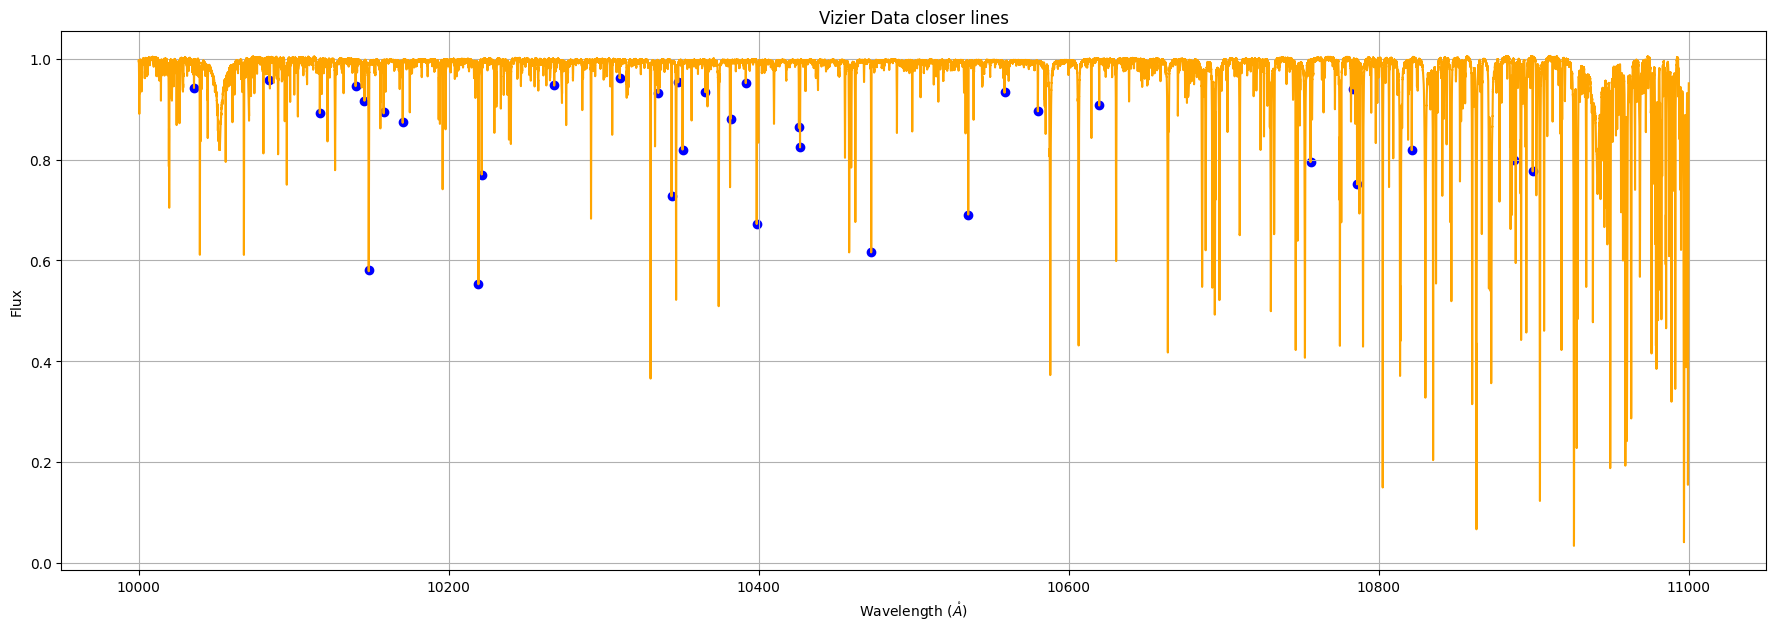

In [13]:
#Plot the identified lines
data_10000_11000 = raw_data[raw_data['Wave A'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)
closer_lines_10000_11000 = closer_lines[closer_lines['Fe line'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)

fig2, ax = plt.subplots(1,1,figsize=(22,7))
ax.plot(data_10000_11000['Wave A'],data_10000_11000['nFlux'], color='orange')
ax.scatter(closer_lines_10000_11000['min_wave'],closer_lines_10000_11000['min_flux'], color='blue')
ax.set_title('Vizier Data closer lines')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel('Flux')
ax.grid()

In [14]:
#Localize the line and save the width for lines
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points


local_points = width_minimums(closer_lines,raw_data,0.05)


### Derivates and fit

In [15]:
def Fit_derivates(local_points,lamda_list):
    values = []
    fit = []
    local = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of Fe I lines 

        #Standarization, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #Take the conditional for the division in zero

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second
        d3_param = poly.polyder(d2_param) #Third

        #The fit values
        flux_fit = poly.polyval(wave_scaled,param)

        #Find the minimum with the regression and derivates
        roots = poly.polyroots(d_param).real #Roots or critical points
        valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] )#Check with the second derivate, just positive values for minimums
        
        if valid_roots.size >0: 

            value_roots = pol(valid_roots) #Evaluate in the polinomium for the global minimum
            minimal_root = valid_roots[np.where(value_roots == min(value_roots))][0] , min(value_roots) #Take the values for the wavelength and the flux of the minimum

            #For the wavelength observed convert the minimal root in the real with the scale of the mean, we dont scale the flux data
            lamda_obs = [round(minimal_root[0]*wave_std + wave_mean,4), minimal_root[1]]

            #Expresion for the third derivate (C-curved profile bisector)
            def Third_Derivate(second, third):
                return -((third)/(3*(second**2)))*(const.c/lamda_obs[0])

            #Evaluate the second and third derivate in the wavelength observed. Re-scalated the coefficients
            d2 = (poly.polyval(minimal_root[0],d2_param) / (wave_std ** 2)) #Core curvature
            d3 = -(Third_Derivate(d2, poly.polyval(minimal_root[0],d3_param) / (wave_std ** 3) )) #Bisector slope

            #Calculate the velocity and convective blueshift
            blueshift = ((lamda_obs[0]/lamda_list[i]) - 1)* const.c
            velocity = round((blueshift) - 5.47) #Formula for relativistic aproximation

            #In order: Natural wavelength, observed wavelength, flux, velocity, second derivate, third derivate, convective blueshift
            values.append(pd.DataFrame([[lamda_list[i],lamda_obs[0],lamda_obs[1],velocity,d2*(lamda_obs[0]**2),d3*(const.c/lamda_obs[0]),blueshift]])) 

            #Just in case of the visualizer take the fit values
            fit.append(flux_fit)
            #Add the local points
            local.append(local_points[i])

    Values =  pd.concat(values,axis=0).reset_index(drop=True)

    Values.columns = ["Emitted wavelength", "Observed wavelength", "Flux","Velocity","Core curvature","Bisector slope","Blueshift"]

    return Values,fit,local

Values,fit,local = Fit_derivates(local_points,closer_lines['Fe line'])

Values

,Emitted wavelength,Observed wavelength,Flux,Velocity,Core curvature,Bisector slope,Blueshift
0,10035.6094,10035.6164,0.942566,204,1.092415e+09,-1.566771e+08,209.110092
1,10084.1584,10084.1685,0.956635,295,1.039917e+09,-9.578404e+07,300.263414
2,10116.7892,10116.7970,0.892116,226,2.487723e+09,-6.268310e+07,231.138667
3,10139.8807,10139.8825,0.945588,48,1.164348e+09,-1.666118e+08,53.218222
4,10145.6242,10145.6287,0.916580,128,1.427904e+09,2.266303e+07,132.970238
...,...,...,...,...,...,...,...
151,17165.7965,17165.8042,0.751673,129,2.868654e+09,9.407380e+06,134.476832
152,17209.0026,17209.0074,0.726489,78,2.297603e+09,5.515178e+07,83.619245
153,17307.0446,17307.0500,0.700314,88,3.115670e+09,-2.068426e+07,93.538747
154,17315.5826,17315.5846,0.928182,29,2.184124e+09,5.904294e+07,34.626898


In [16]:
# import tkinter as tk
# from tkinter import ttk
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
# import numpy as np

# class OutlierViewer:
#     def __init__(self, root, local_points, values, fit):
#         self.root = root
#         self.root.title("Visualizer of Fe I lines identification")
#         self.local_points = local_points
#         self.values = values
#         self.fit = fit
#         self.index = values.index.values
#         self.current_index = 0
       
#         self.setup_ui()
#         self.update_plot()
    
#     def setup_ui(self):
#         main_frame = ttk.Frame(self.root, padding="10")
#         main_frame.pack(fill=tk.BOTH, expand=True)
        
#         control_frame = ttk.Frame(main_frame)
#         control_frame.pack(fill=tk.X, pady=10)
        
#         ttk.Label(control_frame, text="Index of the line:").pack(side=tk.LEFT, padx=5)
#         self.slider = ttk.Scale(
#             control_frame,
#             from_=0,
#             to=len(self.index)-1,
#             orient=tk.HORIZONTAL,
#             command=self.on_slider_move
#         )
#         self.slider.pack(side=tk.LEFT, expand=True, fill=tk.X, padx=5)
        
#         self.spinbox = ttk.Spinbox(
#             control_frame,
#             from_=0,
#             to=len(self.index)-1,
#             width=5,
#             command=self.on_spinbox_change
#         )
#         self.spinbox.pack(side=tk.LEFT, padx=5)
#         self.spinbox.bind("<Return>", self.on_spinbox_change)
        
#         nav_frame = ttk.Frame(control_frame)
#         nav_frame.pack(side=tk.LEFT, padx=10)
        
#         ttk.Button(nav_frame, text="← Last", command=self.prev_plot).pack(side=tk.LEFT)
#         ttk.Button(nav_frame, text="Next →", command=self.next_plot).pack(side=tk.LEFT, padx=5)
     
#         graph_frame = ttk.Frame(main_frame)
#         graph_frame.pack(fill=tk.BOTH, expand=True)
       
#         # Crear figura con dos subplots
#         self.fig, self.axs = plt.subplots(2, 2, figsize=(20, 14))
#         self.ax1, self.ax2,self.ax3, self.ax4 = self.axs.flat
#         self.canvas = FigureCanvasTkAgg(self.fig, master=graph_frame)
#         self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
#         self.toolbar = NavigationToolbar2Tk(self.canvas, graph_frame)
#         self.toolbar.update()
#         self.canvas._tkcanvas.pack(fill=tk.BOTH, expand=True)
    
#     def on_slider_move(self, event=None):
#         self.current_index = int(float(self.slider.get()))
#         self.spinbox.delete(0, tk.END)
#         self.spinbox.insert(0, str(self.current_index))
#         self.update_plot()
    
#     def on_spinbox_change(self, event=None):
#         try:
#             new_index = int(self.spinbox.get())
#             if 0 <= new_index < len(self.index):
#                 self.current_index = new_index
#                 self.slider.set(self.current_index)
#                 self.update_plot()
#         except ValueError:
#             pass
    
#     def prev_plot(self):
#         if self.current_index > 0:
#             self.current_index -= 1
#             self.slider.set(self.current_index)
#             self.spinbox.delete(0, tk.END)
#             self.spinbox.insert(0, str(self.current_index))
#             self.update_plot()
    
#     def next_plot(self):
#         if self.current_index < len(self.index)-1:
#             self.current_index += 1
#             self.slider.set(self.current_index)
#             self.spinbox.delete(0, tk.END)
#             self.spinbox.insert(0, str(self.current_index))
#             self.update_plot()
    
#     def update_plot(self):
#         j = self.current_index
        
#         self.ax1.clear()
#         self.ax2.clear()
#         self.ax3.clear()
#         self.ax4.clear()
        
#         #Plot 1
#         # Fe I line
#         self.ax1.plot(self.local_points[j]['Wave A'],
#                      self.local_points[j]['nFlux'],
#                      c='slateblue')

#         self.ax1.scatter(
#             self.values['Emitted wavelength'].iloc[j],
#             self.values["Flux"].iloc[j],
#             color='slateblue',
#             s=80,
#             label='Emitted wavelength'
#         )

#         self.ax1.scatter(
#             self.values['Observed wavelength'].iloc[j],
#             self.values["Flux"].iloc[j],
#             color='hotpink',
#             s=80,
#             label='Observed wavelength'
#         )

#         # Fit
#         self.ax1.plot(self.local_points[j]['Wave A'],
#                      self.fit[j],
#                      c='hotpink',
#                      marker='.',
#                      label='Fit',
#                      alpha=0.7)
        
#         self.ax1.set_title(f'Line Visualization - Index {self.index[j]} - Wave {self.values["Emitted wavelength"].iloc[j]} Å')
#         self.ax1.set_xlabel(r'Wavelength $(\mathring{A})$')
#         self.ax1.set_ylabel('Flux')
#         self.ax1.grid(True, alpha=0.3)
#         self.ax1.legend()
        
#          # Plot 2 - core curvature
#         self.ax2.scatter(1-self.values['Flux'],
#                         self.values['Core curvature'],
#                         c=self.values["Observed wavelength"],
#                         cmap='rainbow',lw=1,alpha=0.6)
        
#         #Fe I line
#         self.ax2.scatter(
#             1-self.values['Flux'].iloc[j],
#             self.values['Core curvature'].iloc[j],
#             color='hotpink',
#             label='Fe I',
#             s=50,edgecolor='black'
#         )
        
        
#         self.ax2.set_title(f'Core curvature - Value {self.values["Core curvature"].iloc[j]*1e-9:.2f} x10^9')
#         self.ax2.set_xlabel(r'Line depth')
#         self.ax2.set_ylabel('Core curvature')
#         self.ax2.grid(True, alpha=0.3)
#         self.ax2.legend()
        
#         # Plot 3 - bisector slope
#         self.ax3.scatter(1-self.values['Flux'],
#                         self.values['Bisector slope'],
#                         c=self.values["Observed wavelength"],
#                         cmap='rainbow',lw=1,alpha=0.6)
        
#         #Fe I line
#         self.ax3.scatter(
#             1-self.values['Flux'].iloc[j],
#             self.values['Bisector slope'].iloc[j],
#             color='hotpink',
#             label='Fe I',
#             s=50,
#             edgecolor='black'
#         )
        
        
#         self.ax3.set_title(f'Bisector slope - Value {self.values["Bisector slope"].iloc[j]*1e-7:.2f} x10^7')
#         self.ax3.set_xlabel(r'Line depth')
#         self.ax3.set_ylabel('Bisector slope')
#         self.ax3.grid(True, alpha=0.3)
#         self.ax3.legend()

#         # Plot 4 - granulation pattern
#         self.ax4.scatter(1-self.values['Flux'],
#                         self.values['Velocity'],
#                         c=self.values["Observed wavelength"],
#                         cmap='rainbow',lw=1,alpha=0.6)
#         # 
#         #Fe I line
#         self.ax4.scatter(
#             1-self.values['Flux'].iloc[j],
#             self.values['Velocity'].iloc[j],
#             color='hotpink',
#             label='Fe I',
#             s=50,
#             edgecolor='black'
#         )
        
        
#         self.ax4.set_title(f'Granulation pattern - Velocity = {self.values["Velocity"].iloc[j]:.2f} m/s')
#         self.ax4.set_xlabel(r'Line depth')
#         self.ax4.set_ylabel('Relative velocity')
#         self.ax4.grid(True, alpha=0.3)
#         self.ax4.legend()

#         self.fig.tight_layout()
        
#         self.canvas.draw()


# if __name__ == "__main__":
#     root = tk.Tk()
#     root.geometry("1200x700") 
    
#     app = OutlierViewer(root, local_points, Values, fit)
#     root.mainloop()

## Lines to drop in the excel

In [17]:
# index_to_drop = [0,1,2,14,15,22,23,29,37,38,47,48,49,50,51,53,54,55,
#                  58,60,64,65,69,70,71,72,73,74,75,80,83,84,85,89,90,95,
#                  97,98,101,102,104,106,116,117,118,119,120,121,129,134,
#                  138,142,145,146,148,150,157,163,168,169,176,178,180,183,
#                  188,195,203,205,209,211,215,219,222,223,227,232,236,237,
#                  242,243,244,245,247,248,249,252,259,261,269,273,276,277,
#                  278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,
#                  295,296,298,301,302,303,304,305,306,307,308,309,310,311,312,313]

# Values = Values.drop(index_to_drop).reset_index(drop=True)

# Values

In [18]:

#Convert to excel
# Values.to_excel('valores vacio Nave NIR_ultima.xlsx', index=False)

In [19]:
# #Lines from the excel
# raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Visualizer\Clean lines\Nave list NIR.xlsx")
# raw_lambda['Nave list'] = (10**8)/raw_lambda['lambda']
# raw_lambda = raw_lambda[raw_lambda['Nave list'].between(10000,23000,inclusive='right')]
# raw_lambda = raw_lambda[raw_lambda['class']=='A'].reset_index(drop=True)

# raw_lambda

In [20]:
# round(raw_lambda[raw_lambda['Nave list'].between(17165,17180)],4)